# Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sys
sys.path.append('../../')
sys.path.append('../../source_code')
from source_code.utils import current_timestamp

In [2]:
data_path = '/Users/jeremy/data/'
file_name = 'seti_breakthrough_listen_et'
data_path = data_path + file_name

In [3]:
TARGET = 'target'

In [4]:
def get_train_file_path(image_id):
    return f"{data_path}/train/{image_id[0]}/{image_id}.npy"

def get_test_file_path(image_id):
    return f"{data_path}/test/{image_id[0]}/{image_id}.npy"

In [5]:
train = pd.read_csv(data_path + '/train_labels.csv')
train['file_path'] = train['id'].apply(get_train_file_path)
train['file_path'] = train['file_path']#.str.split(prefix).str[-1]

# test = pd.read_csv(data_path + '/sample_submission.csv')
# test['file_path'] = test['id'].apply(get_test_file_path)
# test['file_path'] = test['file_path']#.str.split(prefix).str[-1]

In [6]:
train_df, validation_df = train_test_split(train, test_size=0.1)

In [7]:
train_size = int(train_df.shape[0])
validation_size = int(validation_df.shape[0])
# test_size = int(test.shape[0])
print(train_size, validation_size) #, test_size)

1504 167


In [8]:
train_examples = []
validation_examples = []
# test_examples = []

train_labels = []
validation_labels = []
# test_indexes = []

for i in tqdm(train_df.index[:train_size].to_list()):
    train_examples.append(np.load(train_df.loc[i,'file_path']).reshape(6,273,256))
    train_labels.append(train_df.loc[i,TARGET])

for i in tqdm(validation_df.index[:validation_size].to_list()):
    validation_examples.append(np.load(validation_df.loc[i,'file_path']).reshape(6,273,256))
    validation_labels.append(validation_df.loc[i,TARGET])

# for i in tqdm(test.index[:test_size].to_list()):
#     test_examples.append(np.load(test.loc[i,'file_path']).reshape(6,273,256))
#     test_indexes.append(test.loc[i, 'id'])

100%|██████████| 167/167 [00:00<00:00, 409.40it/s]


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_examples, validation_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices(test_examples)

2021-08-01 16:12:53.955590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100
EPOCHS = 30

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['target'].values),
                                                  train['target'].values)
class_weights = dict(enumerate(class_weights))
class_weights[1] = class_weights[1]*0.75
class_weights

/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 0.5516153152558774, 1: 4.007642735406902}

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import save_model

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(6, 273, 256)))
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 271, 32)        73760     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 269, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 134, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 134, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8576)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1097856   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

In [14]:
callbacks = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,)
model.fit(train_dataset, epochs=EPOCHS, validation_data = validation_dataset, callbacks=[callbacks], class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-08-01 16:14:13.587048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
76/76 [==============================] - 10s 116ms/step - loss: 0.8632 - auc: 0.4999 - val_loss: 0.5818 - val_auc: 0.4284

In [15]:
# save model
current_timestamp_ = current_timestamp()
save_model(model, f'cnn_model_{current_timestamp_}.h5')

In [16]:
losses = pd.DataFrame(model.history.history)
losses

,loss,auc,val_loss,val_auc
0,0.863,0.500,0.582,0.428
1,0.586,0.589,0.599,0.408
2,0.541,0.679,0.503,0.550
3,0.541,0.700,0.527,0.567
4,0.635,0.713,0.570,0.563
5,0.594,0.648,0.655,0.590
6,0.538,0.696,0.584,0.534


<AxesSubplot:>

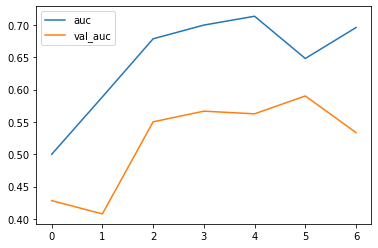

In [17]:
losses[['auc','val_auc']].plot()

<AxesSubplot:>

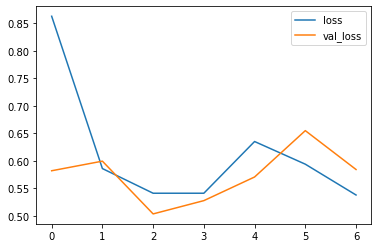

In [18]:
losses[['loss','val_loss']].plot()

In [19]:
preds = model.predict(validation_dataset).flatten()

In [20]:
binary_preds = (preds > 0.5).astype(int)
confusion_matrix(validation_labels, binary_preds)

array([[133,  17],
       [ 16,   1]])

In [21]:
print(classification_report(validation_labels, binary_preds))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       150
           1       0.06      0.06      0.06        17

    accuracy                           0.80       167
   macro avg       0.47      0.47      0.47       167
weighted avg       0.81      0.80      0.80       167



In [22]:
# print(validation_examples[0].shape, test_examples[0].shape)
# print(len(validation_examples), len(test_examples))

In [23]:
# submission_pred = model.predict(test_dataset).flatten()

In [24]:
# submission = pd.DataFrame([test_indexes, submission_pred], index=['id','target']).T
# submission.to_csv(f'submission_{current_timestamp_}.csv')
# submission